In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import episcanpy as epi
import anndata as ad

import matplotlib.pyplot as plt

import time
import pickle
import os

In [2]:
file_path='/home/ubuntu/Mouse_scATACseq_AdultCerebralCortex_10XGenomics/'
base_dir = "{}".format(file_path)

In [3]:
os.listdir(file_path) # shows all files in file_path

['gencode.vM25.basic.annotation.gtf.gz',
 'atac_v1_adult_brain_fresh_5k_singlecell.csv',
 'atac_v1_adult_brain_fresh_5k_fragments.tsv.gz',
 '5k_brain_peaks.narrowPeak',
 '10x-ATAC-Brain5k.h5ad']

In [4]:
name = "5k_brain"

fragments_file = base_dir + "/atac_v1_adult_brain_fresh_5k_fragments.tsv.gz"
peak_file = base_dir + "/{}_peaks.narrowPeak".format(name)
barcode_info = pd.read_csv(base_dir + "/atac_v1_adult_brain_fresh_5k_singlecell.csv")
gtf_file = base_dir + "/gencode.vM25.basic.annotation.gtf.gz"
print(barcode_info.is__cell_barcode.value_counts())

0    494367
1      5337
Name: is__cell_barcode, dtype: int64


In [5]:
valid_barcodes = barcode_info[barcode_info.is__cell_barcode == 1].barcode.tolist()

In [6]:
anno = ad.read(base_dir + "/10x-ATAC-Brain5k.h5ad")
anno

AnnData object with n_obs × n_vars = 2317 × 155093
    obs: 'cell_type', 'domain', 'protocol', 'dataset'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'

In [7]:
anno_per_bc = {bc: anno for bc, anno in zip(anno.obs.index, anno.obs.cell_type)}

In [8]:
adata_raw = epi.ct.peak_mtx(
    fragments_file,
    peak_file,
    valid_bcs = valid_barcodes,
    normalized_peak_size=None,
    fast=False
)

adata_raw

AnnData object with n_obs × n_vars = 5337 × 189587
    var: 'chr', 'start', 'stop'

In [9]:
adata_raw.obs["cell_type"] = [anno_per_bc[bc] if bc in anno_per_bc else "No Annotation" for bc in adata_raw.obs.index.tolist()]
adata_raw.obs

,cell_type
AAACGAAAGTAATCAG-1,L5 IT
AAACGAACACGCTGTG-1,L2/3 IT
AAACGAATCCTGGGAC-1,L6 IT
AAACGAATCGGGAAAC-1,No Annotation
AAACTCGAGAAAGCAG-1,L2/3 IT
...,...
TTTGTGTGTGCTTCCT-1,No Annotation
TTTGTGTGTGGCATAG-1,No Annotation
TTTGTGTTCAGGGTTT-1,L6 CT
TTTGTGTTCTCTGCGT-1,L5 IT


Save the fragment count for normalization later, and binarize for the episcanpy QC pipeline:

In [10]:
print("Max before:\t{}".format(np.max(adata_raw.X)))
adata = epi.pp.binarize(adata_raw, copy = True)
print("Max after:\t{}".format(np.max(adata.X)))
adata.layers["raw_fragments"] = adata_raw.X.copy()
del adata_raw
print("Max before:\t{}".format(np.max(adata.layers["raw_fragments"])))

Max before:	20.0
Max after:	1.0
Max before:	20.0


In [11]:
epi.pp.qc_stats(adata, verbose=True)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features to .obs


In [12]:
epi.pp.nucleosome_signal(adata, fragments_file, n=10000)

In [13]:
epi.pp.tss_enrichment(adata, gtf=gtf_file, fragments=fragments_file, n=5000, score="avg_score_of_center_region", distance_to_tss=1000, bp_per_flank=100)

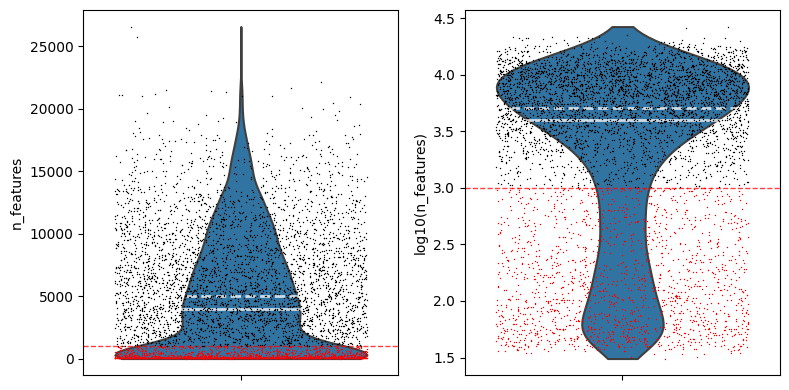

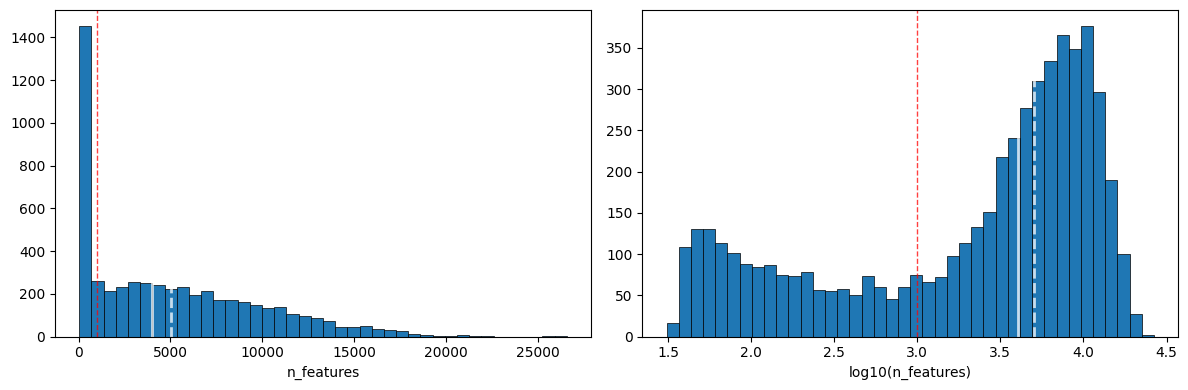

Max:	26571
Median:	4011.0
Mean:	5043.003934794829
Min:	31


In [14]:
min_features = 1000
max_features = None

epi.pl.violin(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_features", bins=40, min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

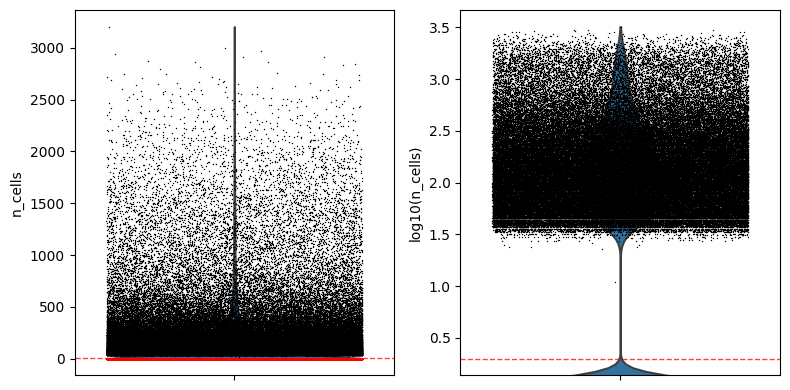

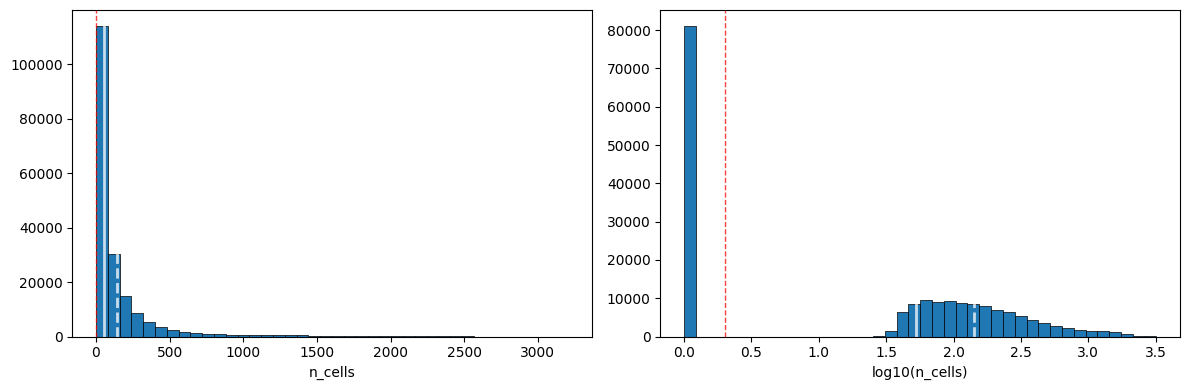

Max:	3206
Median:	53.0
Mean:	141.96391102765486
Min:	0


In [15]:
min_cells = 2
max_cells = None

epi.pl.violin(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_cells", bins=40, min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

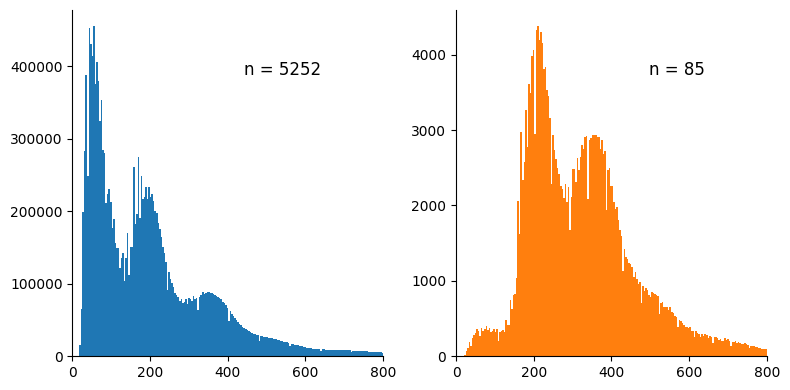

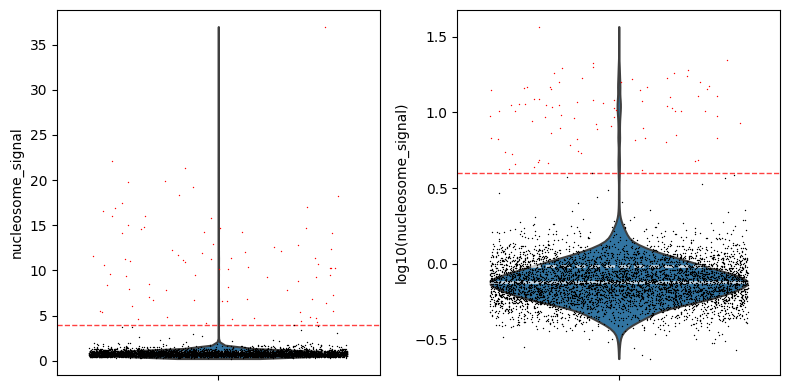

Max:	37.0
Median:	0.7530109759715218
Mean:	0.9569850544263974
Min:	0.23529411764705882


In [16]:
max_nucleosome_signal = 4

epi.pl.fragment_length(adata, n=5000, threshold=max_nucleosome_signal, show_n=True)
epi.pl.violin(adata, "nucleosome_signal", max_threshold=max_nucleosome_signal, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

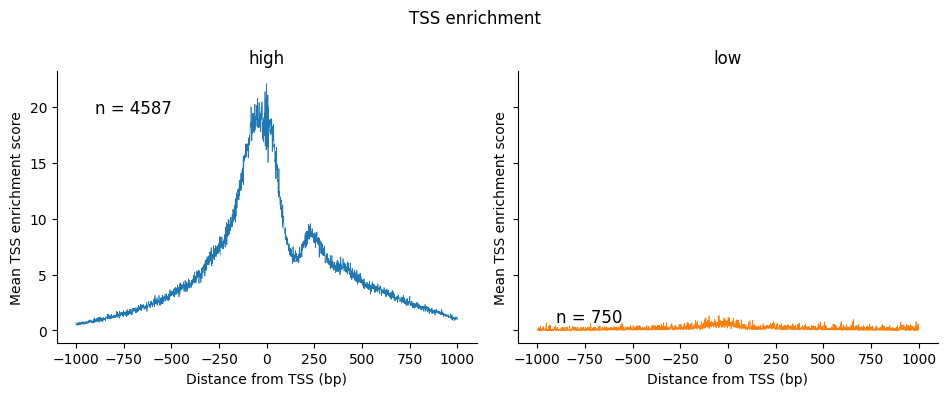

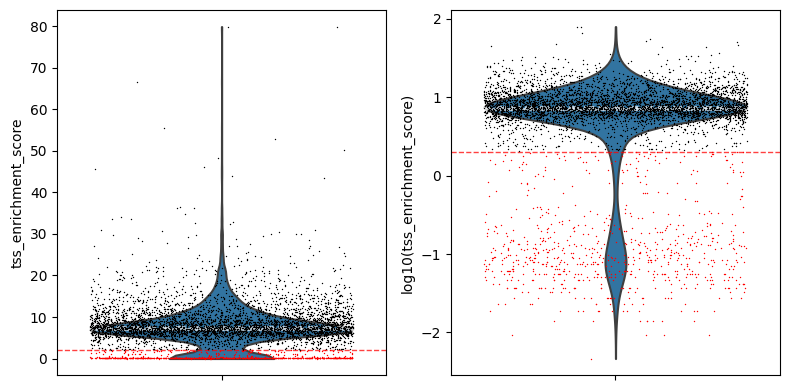

Max:	79.92007992007991
Median:	7.169301286948345
Mean:	7.579842045833907
Min:	0.0


In [17]:
min_tss_enrichment = 2

adata.obs["tss"] = ["high" if val > min_tss_enrichment else "low" for val in adata.obs.tss_enrichment_score]

epi.pl.tss_enrichment(adata, group_by="tss", show_n=True)
epi.pl.violin(adata, "tss_enrichment_score", min_threshold=min_tss_enrichment, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

In [18]:
epi.pp.set_filter(adata, "n_features", min_threshold=min_features, max_threshold=max_features)
epi.pp.set_filter(adata, "nucleosome_signal", max_threshold=max_nucleosome_signal)
epi.pp.set_filter(adata, "tss_enrichment_score", min_threshold=min_tss_enrichment)

epi.pp.set_filter(adata, "n_cells", min_threshold=min_cells)

3741 of 5337 observations remain (-1596)
5252 of 5337 observations remain (-85)
4587 of 5337 observations remain (-750)
108390 of 189587 features remain (-81197)


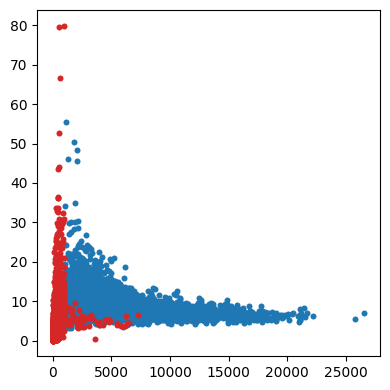

In [19]:
epi.pl.show_filters(adata, x="n_features", y="tss_enrichment_score", save=None)

In [20]:
adata = epi.pp.apply_filters(adata, verbose=True)

3683 of 5337 observations remain (-1654)
108390 of 189587 features remain (-81197)


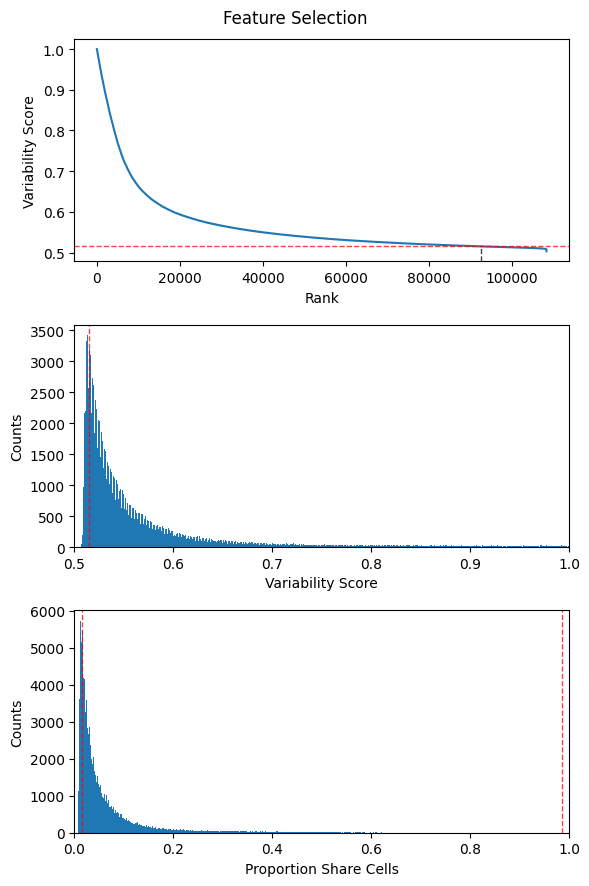

In [21]:
epi.pp.highly_variable(adata, min_score=0.515, n_features=None)

In [22]:
adata = epi.pp.select_highly_variable(adata, verbose=True)

92653 of 108390 features remain (-15737)


In [23]:
adata.layers["binarized"] = adata.X.copy()

In [24]:
epi.pp.normalize_total(adata)
epi.pp.log1p(adata)
adata.layers["epi_normalized"] = adata.X.copy()

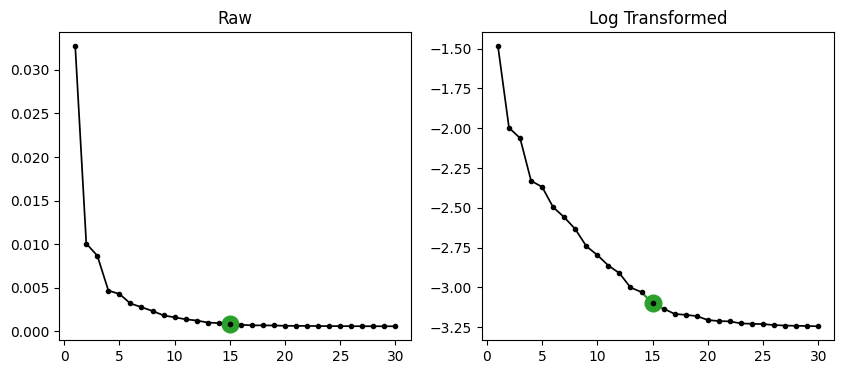

In [25]:
epi.pp.pca(adata, n_comps=30)
n_comps = epi.pp.find_elbow(adata, use_log=True, show_anno=False)

In [26]:
epi.pp.neighbors(adata, n_pcs=n_comps, method="umap")

In [27]:
epi.tl.umap(adata)

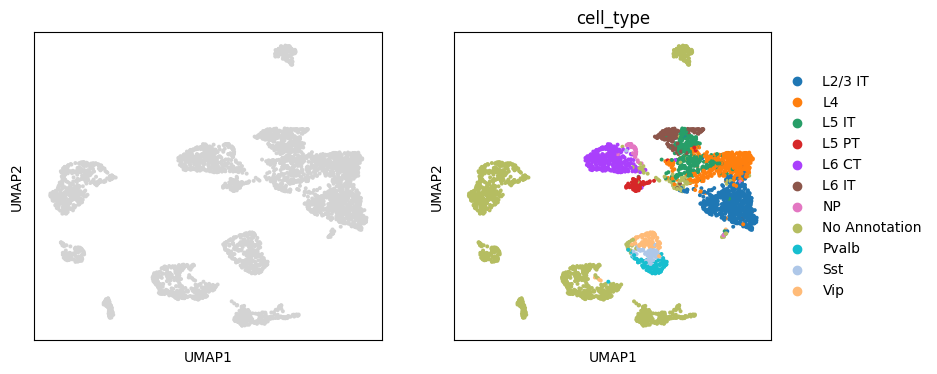

In [28]:
plt.rcParams["figure.figsize"]= (4, 4)
epi.pl.umap(adata, color=[None, "cell_type"])

In [29]:
epi.pp.neighbors(adata, n_pcs=22, method="umap")

In [30]:
epi.tl.umap(adata)

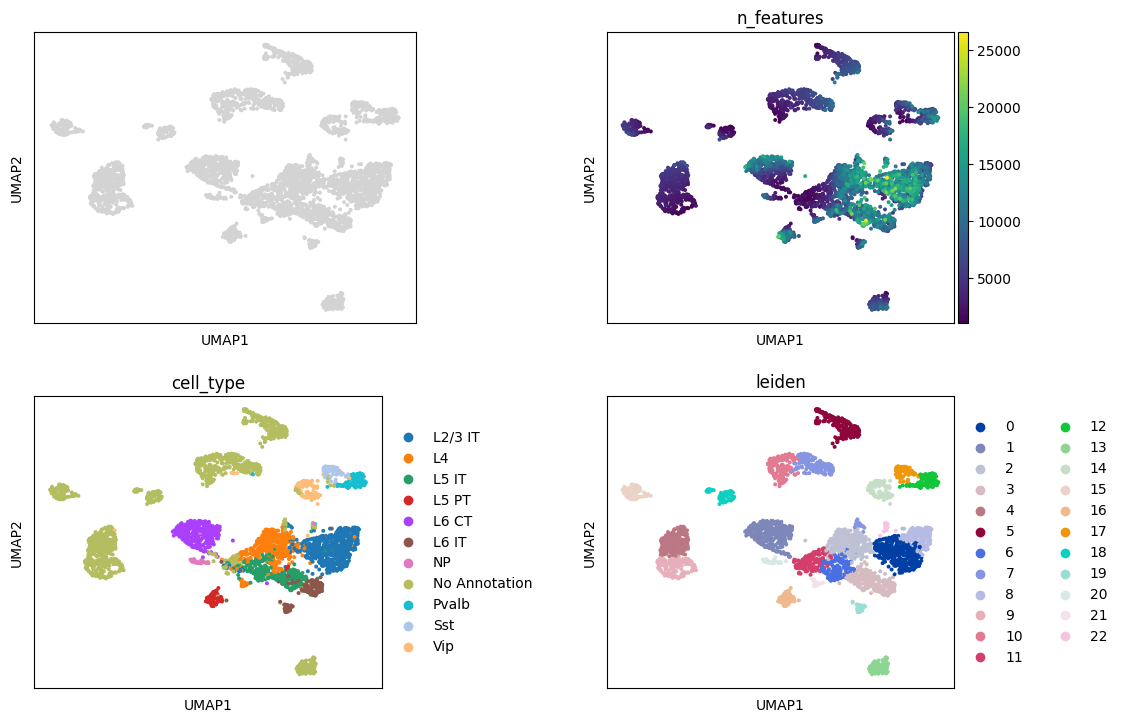

In [31]:
epi.tl.leiden(adata, resolution=1.2)
epi.pl.umap(adata, color=[None, "n_features", "cell_type", "leiden"], ncols=2, wspace=0.5)

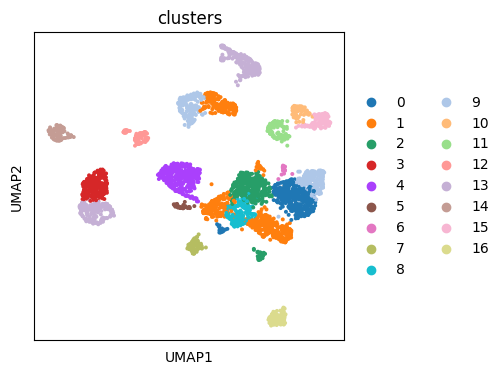

In [32]:
new_clusters = [[0, 21], [7, 11, 3], [2, 19], [4], [1], [20], [22], [16], [6], [8, 10], [17], [14], [18], [5, 9], [15], [12], [13]]
new_clusters = {str(old): str(new) for new, olds in enumerate(new_clusters) for old in olds}

adata.obs["clusters"] = [new_clusters[old_cluster] for old_cluster in adata.obs.leiden]
epi.pl.umap(adata, color=["clusters"])

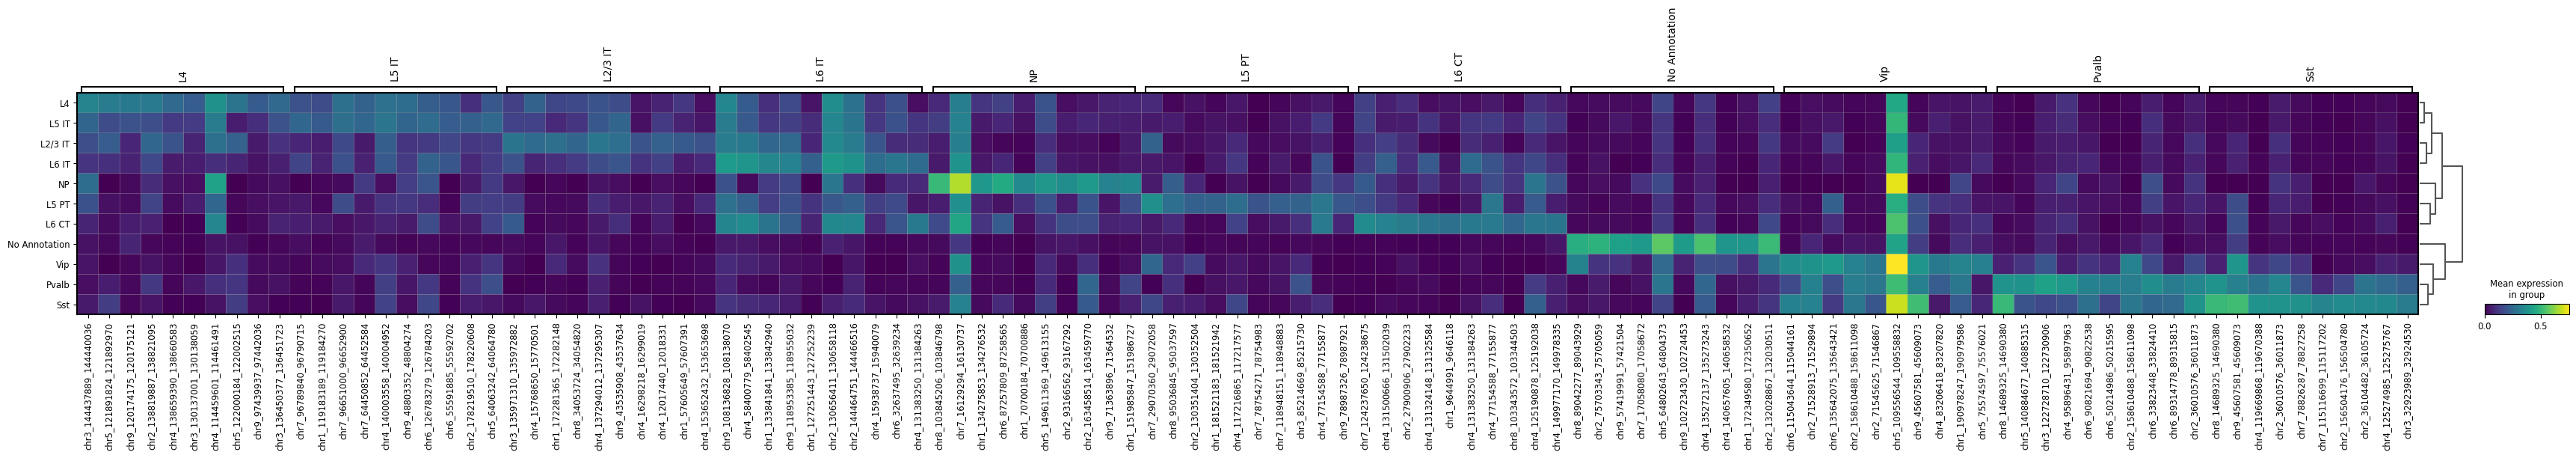

In [33]:
epi.tl.rank_features(adata, groupby="cell_type", use_raw=False, omic="ATAC")
epi.pl.rank_feat_groups_matrixplot(adata)

In [34]:
adata.write("/mnt/storage/adata_QC.h5ad")